<a href="https://colab.research.google.com/github/graviraja/100-Days-of-NLP/blob/applications%2Fgeneration/applications/generation/Masking%20Packing%20Visualization%20BLEU%20on%20MT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook extends the previous notebook on [Bahdanau Attention](https://github.com/graviraja/100-Days-of-NLP/blob/master/applications/generation/Machine%20Translation%20with%20Bahdanau%20Attention.ipynb) by applying the following techniques:
- masking
- packing padded sequences
- visualization of attention 
- bleu score calculation

In [5]:
!pip install torchtext==0.6

     |████████████████████████████████| 71kB 5.4MB/s 
     |████████████████████████████████| 1.1MB 14.9MB/s 
  Found existing installation: torchtext 0.3.1
    Uninstalling torchtext-0.3.1:
      Successfully uninstalled torchtext-0.3.1


In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchtext
from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator
from torchtext.data.metrics import bleu_score

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import random
import time
import numpy as np
import math

In [0]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
!python -m spacy download de
!python -m spacy download en

     |████████████████████████████████| 14.9MB 1.2MB/s 
  Created wheel for de-core-news-sm: filename=de_core_news_sm-2.2.5-cp36-none-any.whl size=14907056 sha256=6ae3d6aa72b48f1dad1fed21723d7874ab72c6837dc7d178aa5cfc71720fc518
  Stored in directory: /tmp/pip-ephem-wheel-cache-ybqdaoiq/wheels/ba/3f/ed/d4aa8e45e7191b7f32db4bfad565e7da1edbf05c916ca7a1ca
Successfully built de-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/de_core_news_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/de
You can now load the model via spacy.load('de')
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [0]:
spacy_de = spacy.load('de')
spacy_en = spacy.load('en')

In [0]:
def tokenize_de(text):
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [0]:
SRC = Field(
    tokenize = tokenize_de,
    init_token = '<sos>',
    eos_token = '<eos>',
    lower = True,
    include_lengths=True
)

TRG = Field(
    tokenize = tokenize_en,
    init_token = '<sos>',
    eos_token = '<eos>',
    lower = True
)

In [7]:
train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), fields=(SRC, TRG))

training.tar.gz:   0%|          | 0.00/1.21M [00:00<?, ?B/s]

downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:00<00:00, 4.61MB/s]
validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 1.33MB/s]

downloading validation.tar.gz
downloading mmt_task1_test2016.tar.gz



mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 1.27MB/s]


In [0]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

In [0]:
BATCH_SIZE = 128

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [0]:
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = BATCH_SIZE,
    sort_within_batch = True,
    sort_key = lambda x: len(x.src),
    device =  device
)

In [0]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, pad_token):
        super().__init__()

        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional=True)
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, src, src_lengths):
        # src => [src_len, batch_size]
        # src_lengths => [batch_size]

        embedded = self.embedding(src)
        embedded = self.dropout(embedded)
        # embedded => [src_len, batch_size, emb_dim]

        pack_padded_sequences = nn.utils.rnn.pack_padded_sequence(embedded, src_lengths)

        packed_outputs, hidden = self.rnn(pack_padded_sequences)

        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs)
        # outputs => [src_len, batch_size, hidden_dim * 2]
        # hidden => [n_layers * num_dir, batch_size, hidden_dim]
        #        => [2, batch_size, hidden_dim]

        forward_hidden = hidden[0, :, :]
        # forward_hidden => [batch_size, hidden_dim]

        backward_hidden = hidden[1, :, :]
        # backward_hidden => [batch_size, hidden_dim]

        combined_hidden = torch.cat((forward_hidden, backward_hidden), dim=1)
        # combined_hidden => [batch_size, hidden_dim * 2]

        decoder_initial_hidden = torch.tanh(self.fc(combined_hidden))
        # decoder_initial_hidden => [batch_size, hidden_dim]

        return outputs, decoder_initial_hidden


In [0]:
class BahdanauAttention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs, mask):
        
        # hidden => [batch_size, dec_hid_dim]
        # encoder_outputs => [src_len, batch_size, enc_hid_dim * 2]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        # repeat decoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        # hidden => [batch_size, src_len, dec_hid_dim]
  
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        # encoder_outputs => [batch_size, src_len, enc_hid_dim * 2]
 
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2)))         
        # energy => [batch_size, src_len, dec_hid_dim]

        attention = self.v(energy).squeeze(2)
        # attention => [batch size, src len]
        
        # reduce the values of attention where the input is padded
        attention = attention.masked_fill(mask == 0, -1e10)
        
        return F.softmax(attention, dim = 1)


In [0]:
class Decoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, attn, dropout, pad_token):
        super().__init__()

        self.output_dim = input_dim
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim + (enc_hid_dim * 2), dec_hid_dim)
        self.attn = attn
        self.fc = nn.Linear(emb_dim + dec_hid_dim + (enc_hid_dim * 2), input_dim)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, input, hidden, encoder_outputs, mask):
        # input => [batch_size]
        # hidden => [batch_size, hidden_dim]
        # encoder_outputs => [src_len, batch_size, enc_hid_dim * 2]
        # mask => [batch_size, src_len]

        input = input.unsqueeze(0)
        # input => [1, batch_size]

        embedded = self.embedding(input)
        embedded = self.dropout(embedded)
        # embedded => [1, batch_size, emb_dim]

        attention_energies = self.attn(hidden, encoder_outputs, mask)
        # attention_energies => [batch_size, src_len]

        attention_energies = attention_energies.unsqueeze(1)
        # attention_energies => [batch_size, 1, src_len]

        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        # encoder_outputs => [batch_size, src_len, enc_hid_dim * 2]

        weighted = torch.bmm(attention_energies, encoder_outputs)
        # weighted => [batch_size, 1, enc_hid_dim * 2]

        weighted = weighted.permute(1, 0, 2)
        # weighted => [1, batch_size, enc_hid_dim * 2]

        combined_rnn_input = torch.cat((embedded, weighted), dim=2)
        # combined_rnn_input => [1, batch_size, emb_dim + enc_hid_dim * 2]

        output, hidden = self.rnn(combined_rnn_input, hidden.unsqueeze(0))
        # output => [1, batch_size, dec_hid_dim]
        # hidden => [1, batch_size, dec_hid_dim]

        combined_out_input = torch.cat((output, weighted, embedded), dim=2)
        # combined_out_input => [1, batch_size, emb_dim + enc_hid_dim * 2 + dec_hid_dim]

        combined_out_input = combined_out_input.squeeze(0)
        # combined_out_input => [batch_size, emb_dim + enc_hid_dim * 2 + dec_hid_dim]

        logits = self.fc(combined_out_input)
        # logits => [batch_size, output_dim]

        return logits, hidden.squeeze(0), attention_energies.squeeze(1)

In [0]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device, src_pad_idx):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.src_pad_idx = src_pad_idx

    def create_mask(self, src):
        # src => [src_len, batch_size]

        mask = (src != self.src_pad_idx)
        mask = mask.permute(1, 0)
        # mask => [batch_size, src_len]
        
        return mask
    
    def forward(self, src, src_len, trg, teacher_forcing_ratio=0.5):
        # src => [src_len, batch_size]
        # src_len => [batch_size]
        # trg => [trg_len, batch_size]

        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        output_dim = self.decoder.output_dim

        outputs = torch.zeros(trg_len, batch_size, output_dim).to(self.device)
        # outputs => [trg_len, batch_size, output_dim]

        encoder_outputs, hidden = self.encoder(src, src_len)
        # encoder_outputs => [src_len, batch_size, enc_hid_dim * 2]
        # hidden => [batch_size, dec_hid_dim]

        dec_inp = trg[0, :]
        # dec_inp => [batch_size]

        mask = self.create_mask(src)
        # mask => [batch_size, src_len]
        
        for i in range(1, trg_len):
            output, hidden, _ = self.decoder(dec_inp, hidden, encoder_outputs, mask)
            outputs[i] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            dec_inp = trg[i] if teacher_force else top1
        return outputs


In [0]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
DROPOUT = 0.5
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

attn = BahdanauAttention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DROPOUT, SRC_PAD_IDX)
dec = Decoder(OUTPUT_DIM, EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, attn, DROPOUT, TRG_PAD_IDX)
model = Seq2Seq(enc, dec, device, SRC_PAD_IDX).to(device)

In [17]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7855, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(5893, 256)
    (rnn): GRU(1280, 512)
    (attn): BahdanauAttention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (fc): Linear(in_features=1792, out_features=5893, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [18]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 20,518,917 trainable parameters


In [0]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [0]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src, src_len = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, src_len, trg)
   
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
             
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [0]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src, src_len = batch.src
            trg = batch.trg

            output = model(src, src_len, trg, 0) #turn off teacher forcing

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [0]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [23]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 43s
	Train Loss: 5.038 | Train PPL: 154.181
	 Val. Loss: 4.750 |  Val. PPL: 115.583
Epoch: 02 | Time: 0m 44s
	Train Loss: 4.128 | Train PPL:  62.055
	 Val. Loss: 4.184 |  Val. PPL:  65.615
Epoch: 03 | Time: 0m 45s
	Train Loss: 3.383 | Train PPL:  29.468
	 Val. Loss: 3.607 |  Val. PPL:  36.848
Epoch: 04 | Time: 0m 45s
	Train Loss: 2.892 | Train PPL:  18.031
	 Val. Loss: 3.363 |  Val. PPL:  28.867
Epoch: 05 | Time: 0m 45s
	Train Loss: 2.508 | Train PPL:  12.280
	 Val. Loss: 3.261 |  Val. PPL:  26.067
Epoch: 06 | Time: 0m 46s
	Train Loss: 2.209 | Train PPL:   9.108
	 Val. Loss: 3.321 |  Val. PPL:  27.686
Epoch: 07 | Time: 0m 46s
	Train Loss: 1.970 | Train PPL:   7.169
	 Val. Loss: 3.191 |  Val. PPL:  24.304
Epoch: 08 | Time: 0m 46s
	Train Loss: 1.763 | Train PPL:   5.829
	 Val. Loss: 3.242 |  Val. PPL:  25.597
Epoch: 09 | Time: 0m 46s
	Train Loss: 1.625 | Train PPL:   5.080
	 Val. Loss: 3.301 |  Val. PPL:  27.127
Epoch: 10 | Time: 0m 46s
	Train Loss: 1.509 | Train PPL

In [24]:

model.load_state_dict(torch.load('model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 3.172 | Test PPL:  23.845 |


In [0]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len=50):

    model.eval()

    # tokenization        
    if isinstance(sentence, str):
        nlp = spacy.load('de')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]
    tokens = [src_field.init_token] + tokens + [src_field.eos_token]

    # convert the tokens to ids  
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    
    # convert to tensor format
    # since the inference is done on single sentence, batch size is 1
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)

    src_len = torch.LongTensor([len(src_indexes)]).to(device)
    
    # encode the input sentence
    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor, src_len)

    # mask of the input sentence
    mask = model.create_mask(src_tensor)
    
    # the starting input to decoder is always <sos>
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    # to store attentions 
    attentions = torch.zeros(max_len, 1, len(src_indexes)).to(device)
    # attentions => [max_len, 1, src_len]
    
    # decode upto a length of max_len
    for i in range(max_len):

        # convert the decoder input to tensor format
        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
        
        # decode the input
        with torch.no_grad():
            output, hidden, attention = model.decoder(trg_tensor, hidden, encoder_outputs, mask)

        # store the attention
        attentions[i] = attention
        
        # get the predicted token by considering the token with highest score
        pred_token = output.argmax(1).item()
        
        # add to predicted tokens
        trg_indexes.append(pred_token)

        # if the predicted token is <eos> means stop the decoding
        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    # convert the predicted token ids to words
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attentions[:len(trg_tokens)-1]

In [0]:
def display_attention(sentence, translation, attention):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)

    attention = attention.squeeze(1).cpu().detach().numpy()

    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=15)
    ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                       rotation=45)
    ax.set_yticklabels(['']+translation)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

src = ['ein', 'kleines', 'kind', 'steht', 'allein', 'auf', 'einem', 'zerklüfteten', 'felsen', '.']
trg = ['a', 'young', 'child', 'is', 'standing', 'alone', 'on', 'some', 'jagged', 'rocks', '.']
predicted trg = ['a', 'small', 'child', 'standing', 'alone', 'on', 'a', 'rock', '.', '<eos>']


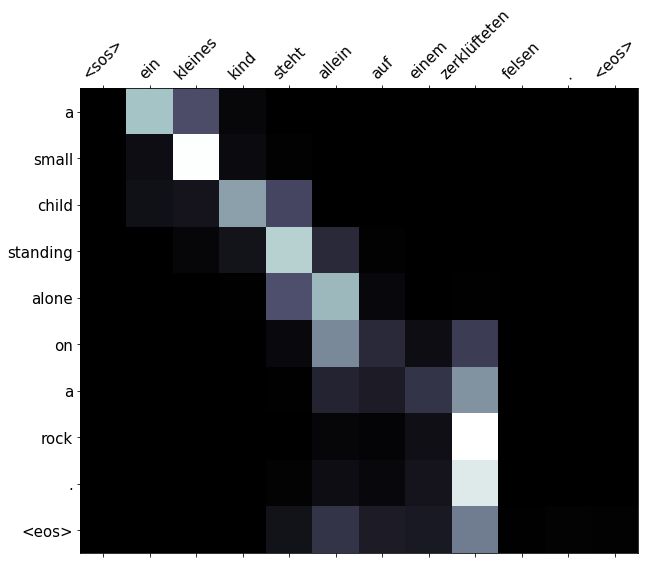

In [29]:

example_idx = 10

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'src = {src}')
print(f'trg = {trg}')
print(f'predicted trg = {translation}')

display_attention(src, translation, attention)

src = ['zwei', 'hunde', 'spielen', 'im', 'hohen', 'gras', 'mit', 'einem', 'orangen', 'spielzeug', '.']
trg = ['two', 'dogs', 'play', 'with', 'an', 'orange', 'toy', 'in', 'tall', 'grass', '.']
predicted trg = ['two', 'dogs', 'play', 'in', 'the', 'grass', 'with', 'an', 'orange', 'toy', '.', '<eos>']


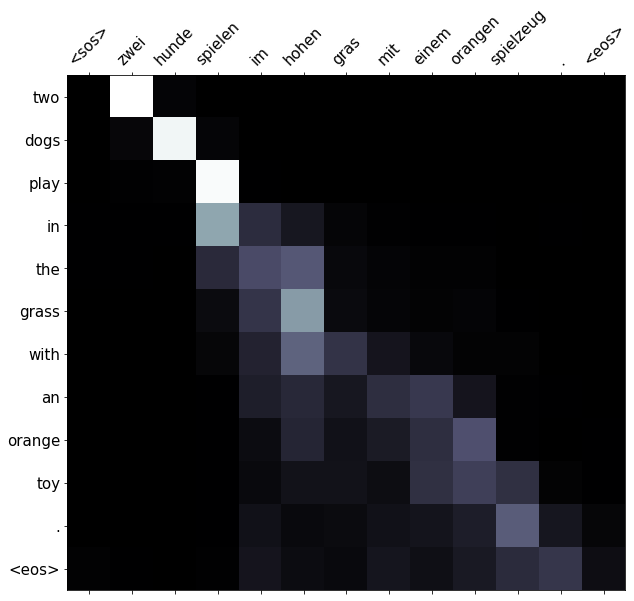

In [33]:
example_idx = 25

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'src = {src}')
print(f'trg = {trg}')
print(f'predicted trg = {translation}')

display_attention(src, translation, attention)

In [0]:
def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for datapoint in data:
        
        src = vars(datapoint)['src']
        trg = vars(datapoint)['trg']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        # ignore <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

In [35]:
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 29.44


We get a BLEU of around 29. If we compare it to the paper that the attention model is attempting to replicate, they achieve a BLEU score of 26.75. This is similar to our score, however they are using a completely different dataset and their model size is much larger - 1000 hidden dimensions which takes 4 days to train! - so we cannot really compare against that either.

This number isn't really interpretable, we can't really say much about it. The most useful part of a BLEU score is that it can be used to compare different models on the same dataset, where the one with the higher BLEU score is "better".